# Overlap algorithm

In [8]:
from overlap import *

In [9]:
#Testcase of three different 'tissue types'
test = [
    [1,4,6,7,12,16], #tissue 1
    [4,14,16,17], #tissue 2
    [1,4,12,16,21,24] #tissue 3
]

# n2_overlap is the brute force method to show that the sweepline approach is correct
n2_overlap(test), sweepline_overlap(test)

(array([[3., 4., 2.],
        [4., 2., 3.],
        [2., 3., 3.]]),
 array([[3., 4., 2.],
        [4., 2., 3.],
        [2., 3., 3.]]))

# HCS clustering

In [10]:
import networkx as nx
import numpy as np
from HCS import HCS

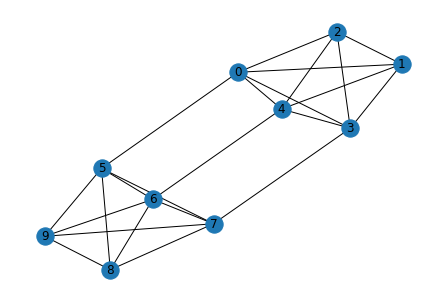

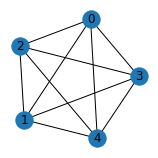

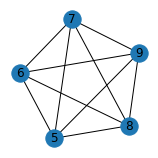

In [11]:
similarity_matrix = np.array([
                            [1,1,1,1,1,1,0,0,0,0],
                            [1,1,1,1,1,0,0,0,0,0],
                            [1,1,1,1,1,0,0,0,0,0],
                            [1,1,1,1,1,0,0,1,0,0],
                            [1,1,1,1,1,0,1,0,0,0],
                            [1,0,0,0,0,1,1,1,1,1],
                            [0,0,0,0,1,1,1,1,1,1],
                            [0,0,0,1,0,1,1,1,1,1],
                            [0,0,0,0,0,1,1,1,1,1],
                            [0,0,0,0,0,1,1,1,1,1]
                            ])

HCS_model = HCS(similarity_matrix)
clusters = HCS_model.cluster(sim_threshold = 1) #2 nodes only get an edge if similarity is at least 1

HCS_model.drawGraphs() #draw original graph and the two highly connected subgraphs